In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [2]:
tf.random.set_seed(0)

# Check the heuristics to select nosie variance

In [3]:
from src.ksd.kernel import median_heuristic, l2norm
from experiments.compare_samplers import create_mixture_gaussian

In [ ]:
dim = 5
n = 500

# Oracle choice of variance

In [55]:
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)

samples_on = target.sample(n)
samples_off = target_off.sample(n)

In [56]:
var = 5.
convolution = tfd.MultivariateNormalDiag(0., tf.math.sqrt(var) * tf.ones(dim))
samples_on_convolved = samples_on + convolution.sample(n)
samples_off_convolved = samples_off + convolution.sample(n)

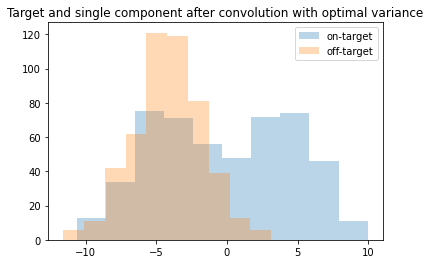

In [58]:
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component after convolution with optimal variance")

# Med heuristic

In [60]:
med_ls = []
delta_ls = np.linspace(1., 10, 100)
for delta in tqdm(delta_ls):
    target = create_mixture_gaussian(dim=dim, delta=delta)
    samples = target.sample(500)
    l2norm_mat = l2norm(samples, tf.identity(samples))
    med_ls.append(median_heuristic(l2norm_mat) / dim)
    

  0%|          | 0/100 [00:00<?, ?it/s]

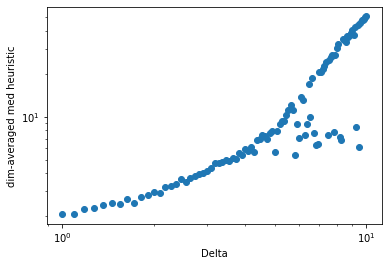

In [61]:
plt.scatter(delta_ls, med_ls)
plt.xscale("log")
plt.yscale("log")
_ = plt.xlabel("Delta")
_ = plt.ylabel("dim-averaged med heuristic")

In [62]:
delta = delta_ls[33]
var = med_ls[33].numpy()

In [63]:
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)

samples_on = target.sample(n)
samples_off = target_off.sample(n)

convolution = tfd.MultivariateNormalDiag(0., tf.math.sqrt(var) * tf.ones(dim))
samples_on_convolved = samples_on + convolution.sample(n)
samples_off_convolved = samples_off + convolution.sample(n)

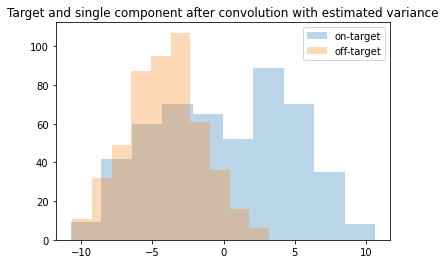

In [64]:
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component after convolution with estimated variance")

# Pairwise difference as noise distribution

In [7]:
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)
    
samples_on = target.sample(500)
samples_off = target_off.sample(500)

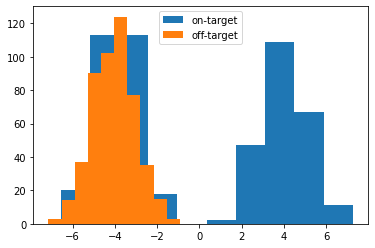

In [9]:
_ = plt.hist(samples_on.numpy()[:, 0], label="on-target")
_ = plt.hist(samples_off.numpy()[:, 0], label="off-target")
plt.legend()

In [40]:
n = samples_on.shape[0]
noise_samples = []
for i in range(n):
    for j in range(n):
        noise_samples.append(samples_on[i, :] - samples_on[j, :])

noise_samples = tf.convert_to_tensor(noise_samples, dtype=tf.float32)

In [41]:
noise_dist = tfp.distributions.Empirical(noise_samples, event_ndims=1)

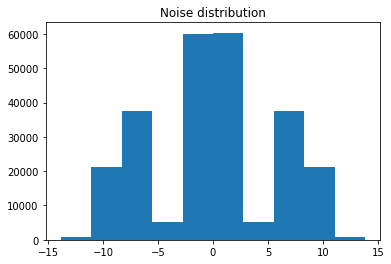

In [42]:
_ = plt.hist(noise_samples.numpy()[:, 0])
_ = plt.title("Noise distribution")

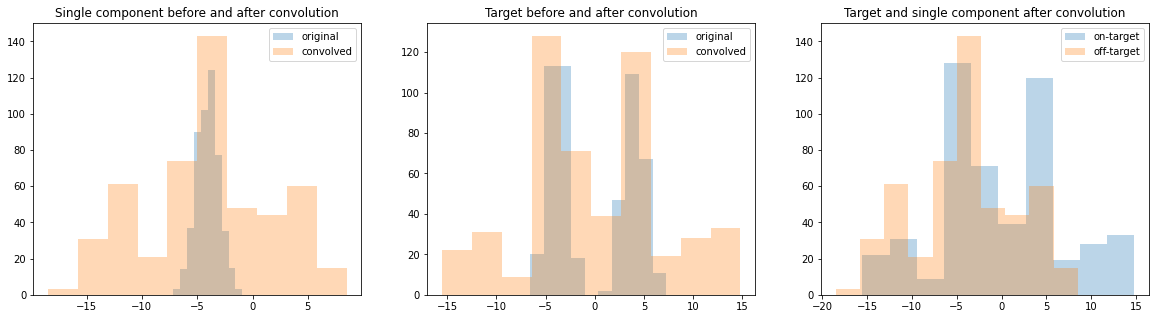

In [53]:
xx = noise_dist.sample(500)
samples_off_convolved = samples_off + xx

plt.figure(figsize=(20, 5))
plt.subplot(131)
_ = plt.hist(samples_off.numpy()[:, 0], label="original", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="convolved", alpha=0.3)
_ = plt.legend()
_ = plt.title("Single component before and after convolution")

plt.subplot(132)
samples_on_convolved = samples_on + xx
_ = plt.hist(samples_on.numpy()[:, 0], label="original", alpha=0.3)
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="convolved", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target before and after convolution")

plt.subplot(133)
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component after convolution")
